In [29]:
import os
import cv2
import glob
import imutils
import numpy as np

# Folder containing CAPTCHA images and output path for letter images
CAPTCHA_IMAGE_FOLDER = r"C:\Users\gowri\OneDrive\Desktop\captha solver\generated_captcha_images"
OUTPUT_FOLDER = r"C:\Users\gowri\OneDrive\Desktop\captha solver\output"

# Get list of CAPTCHA image files
captcha_image_files = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER, "*.png"))
counts = {}

# Process each CAPTCHA image
for (i, captcha_image_file) in enumerate(captcha_image_files):
    print(f"[INFO] processing image {i + 1}/{len(captcha_image_files)}: {captcha_image_file}")

    # Extract correct CAPTCHA text from filename (e.g., "3H5D.png" → "3H5D")
    filename = os.path.basename(captcha_image_file)
    captcha_correct_text = os.path.splitext(filename)[0]

    # Read and preprocess image
    image = cv2.imread(captcha_image_file)
    if image is None:
        print(f"[WARNING] Could not read image: {captcha_image_file}")
        continue

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Find contours
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    letter_image_regions = []

    for contour in contours:
        # Skip if contour is not valid
        if contour is None or len(contour) == 0 or not isinstance(contour, np.ndarray):
            continue
        if contour.dtype != np.int32 and contour.dtype != np.float32:
            contour = contour.astype(np.int32)

        # Try-catch block for safety
        try:
            (x, y, w, h) = cv2.boundingRect(contour)
        except Exception as e:
            print(f"[WARNING] Skipping invalid contour: {e}")
            continue

        if w / h > 1.25:
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            letter_image_regions.append((x, y, w, h))

    # Ensure only valid CAPTCHAs with 4 letters are processed
    if len(letter_image_regions) != 4:
        print(f"[WARNING] Skipping image due to {len(letter_image_regions)} detected letters: {filename}")
        continue

    # Sort by x-coordinate (left to right)
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Save each letter as an individual image
    for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_correct_text):
        x, y, w, h = letter_bounding_box
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

        save_path = os.path.join(OUTPUT_FOLDER, letter_text)
        os.makedirs(save_path, exist_ok=True)

        count = counts.get(letter_text, 1)
        file_path = os.path.join(save_path, f"{str(count).zfill(6)}.png")
        cv2.imwrite(file_path, letter_image)
        counts[letter_text] = count + 1


[INFO] processing image 1/1136: C:\Users\gowri\OneDrive\Desktop\captha solver\generated_captcha_images\2A2X.png
[INFO] processing image 2/1136: C:\Users\gowri\OneDrive\Desktop\captha solver\generated_captcha_images\2A5R.png
[INFO] processing image 3/1136: C:\Users\gowri\OneDrive\Desktop\captha solver\generated_captcha_images\2A5Z.png
[INFO] processing image 4/1136: C:\Users\gowri\OneDrive\Desktop\captha solver\generated_captcha_images\2A98.png
[INFO] processing image 5/1136: C:\Users\gowri\OneDrive\Desktop\captha solver\generated_captcha_images\2A9N.png
[INFO] processing image 6/1136: C:\Users\gowri\OneDrive\Desktop\captha solver\generated_captcha_images\2AD9.png
[INFO] processing image 7/1136: C:\Users\gowri\OneDrive\Desktop\captha solver\generated_captcha_images\2AEF.png
[INFO] processing image 8/1136: C:\Users\gowri\OneDrive\Desktop\captha solver\generated_captcha_images\2APC.png
[INFO] processing image 9/1136: C:\Users\gowri\OneDrive\Desktop\captha solver\generated_captcha_images\2

In [33]:
import cv2
import pickle
import os.path
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from helpers import resize_to_fit

# Constants
LETTER_IMAGES_FOLDER = r"C:\Users\gowri\OneDrive\Desktop\captha solver\output"
MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"

# Initialize data and labels
data = []
labels = []

# Loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image (for Keras)
    image = np.expand_dims(image, axis=2)

    # Grab the label (the folder name)
    label = image_file.split(os.path.sep)[-2]

    # Add image and label to the dataset
    data.append(image)
    labels.append(label)

# Convert and scale data
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Split into training and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Binarize the labels (convert to one-hot)
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

# Save the label binarizer to disk
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

# Build the CNN model
model = Sequential()

# First convolutional + max-pooling layer
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional + max-pooling layer
model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(500, activation="relu"))
model.add(Dense(32, activation="softmax"))  # Adjust 32 based on number of classes

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=32)

# Save the trained model
model.save(MODEL_FILENAME)

# Print model summary
model.summary()


C:\Users\gowri\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.3152 - loss: 2.5500 - val_accuracy: 0.9409 - val_loss: 0.2147
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9718 - loss: 0.1520 - val_accuracy: 0.9866 - val_loss: 0.0751
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9910 - loss: 0.0425 - val_accuracy: 0.9919 - val_loss: 0.0490
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9976 - loss: 0.0141 - val_accuracy: 0.9910 - val_loss: 0.0544
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9999 - loss: 0.0064 - val_accuracy: 0.9919 - val_loss: 0.0442
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9928 - val_loss: 0.0439
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 1.0000 - loss: 7.2199e-04 - val_accuracy: 0.9937 - val_loss: 0.0457
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 1.0000 - loss: 5.8734e-04 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 20, 20, 20)          │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 10, 10, 20)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 50)          │          25,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 50)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1250)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │         625,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │          16,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,001,308 (7.63 MB)

 Trainable params: 667,102 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,334,206 (5.09 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
CAPTCHA text is: 3HHL


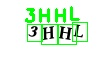

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
CAPTCHA text is: 4J7N


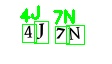

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
CAPTCHA text is: 7V9B


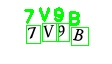

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
CAPTCHA text is: 4G37


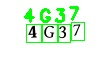

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
CAPTCHA text is: E7KU


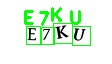

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
CAPTCHA text is: B7UX


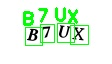

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
CAPTCHA text is: C2WZ


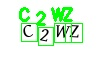

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
CAPTCHA text is: E4LC


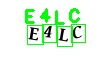

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
CAPTCHA text is: M6GW


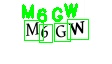

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
CAPTCHA text is: 77J8


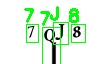

In [37]:
from keras.models import load_model
from helpers import resize_to_fit
from imutils import paths
import numpy as np
import imutils
import cv2
import pickle
import os

from IPython.display import Image, display

MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"
CAPTCHA_IMAGE_FOLDER = r"C:\Users\gowri\OneDrive\Desktop\captha solver\generated_captcha_images"

# Load the model labels
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

# Load the trained neural network
model = load_model(MODEL_FILENAME)

# Grab a few random CAPTCHA images
captcha_image_files = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
captcha_image_files = np.random.choice(captcha_image_files, size=(10,), replace=False)

# Process each image
for image_file in captcha_image_files:
    image = cv2.imread(image_file)
    if image is None:
        print(f"[WARNING] Could not read image: {image_file}")
        continue

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.copyMakeBorder(gray, 20, 20, 20, 20, cv2.BORDER_REPLICATE)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Find contours
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    letter_image_regions = []

    for contour in contours:
        if contour is None or len(contour) == 0 or not isinstance(contour, np.ndarray):
            continue
        if contour.dtype != np.int32 and contour.dtype != np.float32:
            contour = contour.astype(np.int32)

        try:
            (x, y, w, h) = cv2.boundingRect(contour)
        except Exception as e:
            print(f"[WARNING] Skipping invalid contour: {e}")
            continue

        if w / h > 1.25:
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            letter_image_regions.append((x, y, w, h))

    if len(letter_image_regions) != 4:
        print(f"[INFO] Skipping image due to incorrect number of letters: {len(letter_image_regions)} in {os.path.basename(image_file)}")
        continue

    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    output = cv2.merge([gray] * 3)
    predictions = []

    for letter_bounding_box in letter_image_regions:
        x, y, w, h = letter_bounding_box
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]
        letter_image = resize_to_fit(letter_image, 20, 20)

        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)

        prediction = model.predict(letter_image)
        letter = lb.inverse_transform(prediction)[0]
        predictions.append(letter)

        cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
        cv2.putText(output, letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)

    captcha_text = "".join(predictions)
    print(f"CAPTCHA text is: {captcha_text}")

    # Show the result image in Jupyter notebook
    result_file = 'workaround.jpg'
    cv2.imwrite(result_file, output)
    display(Image(filename=result_file))
